# Import Telemetry class


In [1]:
%matplotlib widget
from TMclass import *
import datetime
fromiso = datetime.datetime.fromisoformat
tdelta = datetime.timedelta
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xml.etree import ElementTree
import os





Leggo il csv come (t,fcp,id), in cui id ha un certo numero di entrate. Creo PHI dal primo orario - 1 giorno o lo creo a mano

In [2]:
PHI = PHI_MEMORY(fromiso('2022-03-05T00:00:00'))

def load_csv(fname):
    import pandas as pd

    dateparse = lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S')

    dur = pd.read_csv('/home/calchetti/Desktop/phi_proc_time.lst')

    cols = ['start','fcp']
    maxNumParams = 63 # 51 before winter 2023 # 35 before macros implementation
    for i in range(maxNumParams):
        cols.append('FP_'+str(i+1))

    df = pd.read_csv(fname, names=cols, keep_default_na=False, index_col=False, parse_dates=[0], date_parser=dateparse)
    # df = df[df.fcp != 'TMPGAP']
    df.insert(loc=1, column='end', value=None, allow_duplicates=True)
    df = df.query("fcp != 'TMPGAP'")
    df = df.query("fcp != 'STDGAP'")
    df = df.query("fcp != 'OBJECT'")
    df = df.query("fcp != 'SUBJECT'")
    df = df.query("fcp != 'PURPOSE'")

    old = 0
    for i in df.index:
        
        mask = np.column_stack([dur[col].str.contains(df.fcp[i], na=False) for col in dur])
        duration = dur.loc[mask.any(axis=1)].duration
        
        if duration.size>1:
            duration = duration.iloc[0]
        
        try:
            duration = float(duration)
        except:
            try:
                temp = duration.values[0]
            except:
                temp = str(duration)
            for j in range(35):
                v = df['FP_'+str(j+1)].loc[i].lstrip('0')
                try:
                    temp = temp.replace('$FP_'+str(j+1),v)
                except:
                    pass
            duration = eval(temp)

        if pd.isnull(df.start[i]):
            df.at[i,'start'] = df.end[old] + tdelta(seconds=20)
        
        if pd.isnull(df.end[i]):
            df.at[i,'end'] = df.at[i,'start'] + tdelta(seconds=duration)
        
        old = i
    
    return df


In [5]:
def levels_did_out(phi_mode):
    def find_levels(s):
        levels = []
        t = []
        
        for k, v in s.__dict__.items():
            if k in ['raw','crop','bin','pack','extr','proc','compr']:
                t += [getattr(s,k)]
                levels += [t[-1].level]
        return levels, t

    levels = []
    temp = [[]]
    temp[0] += [phi_mode]
    i = 0
    while temp[i] != []:
        i += 1
        temp += [[]]
        for t in temp[i-1]:
            l,tt = find_levels(t); levels += l; temp[i] += tt;
        
    # temp = temp[:-1]
    temp = [t for tt in temp[1:] for t in tt]
    return levels, [t.did for t in temp], [t.n_datasets for t in temp]
    
def find_consecutive(obs,did):
    did_int = int(did)
    keys = list(obs.keys()); keys = [i for i in keys if 'copy' not in i]
    start_did = np.asarray(keys,dtype=int)

    n_datasets = np.asarray([obs[k].raw.n_datasets for k in keys],dtype=int)

    cond = start_did - (did_int) + n_datasets == 0
    obs_i = np.where(cond)[0]

    if len(obs_i) == 1:
        obs_i = obs_i[0]; 
        return keys[obs_i]
    elif len(obs_i) > 1:
        print(f'more observations found with this possible consecutive DID: {did}')

def find_did(obs,did,crop = 500,end='\n'):
    keys = list(obs.keys()); keys = [i for i in keys if 'copy' not in i]
    levels = []
    dids = []
    n_datasets = []
    for i,k in enumerate(keys):
        out = levels_did_out(obs[k])
        levels += [[]]
        dids += [[]]
        n_datasets += [[]]
        levels[i] += out[0]
        dids[i] += out[1]
        n_datasets[i] += [max(out[2])]*len(out[2])
        
    all_levels = np.asarray([t for tt in levels for t in tt])
    all_dids = np.asarray([t for tt in dids for t in tt],dtype=int)
    n_datasets = np.asarray([t for tt in n_datasets for t in tt],dtype=int)
    
    # n_datasets = np.asarray([obs[k].raw.n_datasets for k in keys],dtype=int)
    did_int = int(did)
    
    cond1 = all_dids - (did_int) <= 0
    cond2 = all_dids - (did_int) + n_datasets > 0
    # obs_i,obs_j = np.where(cond1*cond2)
    obs_i = np.where(cond1*cond2)[0]
    if obs_i.size == 0:
        return did, None, None, False
    else:
        idx = obs_i[0]
    
    # if np.all(all_levels[obs_i] == all_levels[idx]):
    level = all_levels[idx]
    lev = level
    i = 0
    while lev != 'raw':
        i+=1
        lev = all_levels[idx-i]
    
    start_did = str(all_dids[idx-i]).rjust(10,'0')
    # endif
    lev = obs[start_did].level_out(level)
    
    return start_did,level,lev,True

def run(df,PHI,verbose=False):
    import sys
    import traceback

    obs = {}
    ysize = 2048
    xsize = 2048
    instr = 'HRT'

    for i in range(df.shape[0]):
        try:

            fcp = df.iloc[i].fcp

            # FPS window is restored only when we leave observation mode
            if fcp == 'FCP-002':#
                ysize = 2048
            if fcp == 'FCP-011':#
                ysize = 2048
            if fcp == 'FCP-032':#
                ysize = 2048
            if fcp == 'FCP-033':#
                ysize = 2048
            if fcp == 'FCP-034':#
                ysize = 2048
            if fcp == 'FCP-035':#
                ysize = 2048
            if fcp == 'FCP-036':#
                ysize = 2048
            if fcp == 'FCP-037':#
                ysize = 2048
            if fcp == 'FCP-038':#
                ysize = 2048
            if fcp == 'FCP-039':#
                ysize = 2048
            if fcp == 'FCP-040':#
                ysize = 2048
            if fcp == 'FCP-041':#
                ysize = 2048
            if fcp == 'FCP-042':#
                ysize = 2048
            if fcp == 'FCP-043':#
                ysize = 2048
            
            if fcp == 'FCP-216':#Schedule_Datasets.fcp
                if df.iloc[i+1].fcp != 'FCP-219': #to avoid low latency
                    t0 = df.iloc[i].start.to_pydatetime()
                    t1 = df.iloc[i].end.to_pydatetime()
                    n = 1
                    j = 3
                    while df.iloc[i][j] != '':
                        did = df.iloc[i][j]
                        try:
                            obs_i, level, lev, find = find_did(obs,did,end='\r')
                            if find:
                                kw = obs[obs_i].compressing(t0,ndata=n,nbits=6,level=level,verbose=verbose)
                                PHI.saving(id,**kw)
                            else:
                                print('DID to be flushed not found: '+did,'index:',i)
                        except:
                            print('DID to be flushed not found: '+did,'index:',i)
                            
                        j += 1

            if fcp == 'FCP-217':#Schedule_Consecutive_Datasets.fcp
                if df.iloc[i+1].fcp != 'FCP-219': #to avoid low latency
                    did = df.iloc[i].FP_1
                    t0 = df.iloc[i].start.to_pydatetime()
                    t1 = df.iloc[i].end.to_pydatetime()
                    n = int(df.iloc[i].FP_2)
                    obs_i, level, lev, find = find_did(obs,did,end='\r')
                    if find:
                        kw = obs[obs_i].compressing(t0,ndata=n,nbits=6,level=level,verbose=verbose)
                        PHI.saving(id,**kw)
                    else:
                        print('DID to be flushed not found: '+did,'index:',i)

            if fcp == 'FCP-401':#Prepare_FDT.fcp
                instr = 'FDT'
            
            if fcp == 'FCP-402':#Prepare_HRT.fcp
                instr = 'HRT'
            
            if fcp == 'FCP-405':#Set_Context_for_MTL_Reentry.fcp
                nout = {'HRT':5, 'FDT':5}
                if int(df.iloc[i].FP_13) < 30:
                    nout['HRT'] = 5
                elif int(df.iloc[i].FP_13) >= 30 and int(df.iloc[i].FP_13) < 40:
                    nout['HRT'] = 3
                else:
                    nout['HRT'] = 2
                
                if int(df.iloc[i].FP_27) < 30:
                    nout['FDT'] = 5
                elif int(df.iloc[i].FP_27) >= 30 and int(df.iloc[i].FP_27) < 40:
                    nout['FDT'] = 3
                else:
                    nout['FDT'] = 2

            if fcp == 'FCP-412':#Delete_Datasets.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = int(df.iloc[i].FP_2)
                obs_i, level, lev, find = find_did(obs,did,end='\r')
                if find:
                    mem = lev.data_tot / lev.n_datasets * n
                    if '.' in level:
                        key = level.split('.')[-1]
                    else:
                        key = level
                    kw = {'tm_type':type(lev), 'val':-mem,\
                    'key':key, 'start':t0, 'end':t1}
                    PHI.saving(id,**kw)
                else:
                    print('DID to be deleted not found: '+did,'index:',i)
            
            if fcp == 'FCP-467':#Set_FPA_Window.fcp
                ysize = (int(df.iloc[i].FP_2) + 2 - int(df.iloc[i].FP_1)) * 2

            if fcp == 'FCP-521':#Acquire_FDT_Flat_Field_Images.fcp
                did = df.iloc[i].FP_3
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 9
                cad = 2
                fdt_flat = PHI_MODE(instr)
                kw = fdt_flat.observation(t0,n,cad,(2048,2048,4,6),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048
            
            if fcp == 'FCP-522':#Process_FDT_Flat_Field_Images.fcp
                did = df.iloc[i].FP_3
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = ((t1 - t0)/n).total_seconds()/60
                obs[did] = PHI_MODE(instr)
                kw = obs[did].observation(t0,t1,cad,(2048,2048,4,6),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048
            
            if fcp == 'FCP-523':#Acquire_HRT_Flat_Field_Images.fcp
                did = df.iloc[i].FP_2
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = 50
                obs[did] = PHI_MODE(instr)
                kw = obs[did].observation(t0,n,cad,(2048,2048,4,6),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048

            if fcp == 'FCP-524':#Process_HRT_Flat_Field_Images.fcp
                did = df.iloc[i].FP_3
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = ((t1 - t0)/n).total_seconds()/60
                obs[did] = PHI_MODE(instr)
                kw = obs[did].observation(t0,t1,cad,(2048,2048,4,6),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048
            
            if fcp == 'FCP-525':#Acquire_HRT_Flat_Field_Images_for_KLL.fcp
                did = df.iloc[i].FP_3
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 9
                cad = 2
                obs[did] = PHI_MODE(instr)
                kw = obs[did].observation(t0,n,cad,(2048,2048,4,6),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048

            if fcp == 'FCP-526':#Process_HRT_Flat_Field_Images_for_KLL.fcp
                did = df.iloc[i].FP_5
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = ((t1 - t0)/n).total_seconds()/60
                obs[did] = PHI_MODE(instr)
                kw = obs[did].observation(t0,t1,cad,(2048,2048,4,6),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048

            if fcp == 'FCP-561':#Perform_FPA_Focus_Scan.fcp
                did = df.iloc[i].FP_1
                obs[did] = PHI_MODE(instr)
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                N = int(df.iloc[i].FP_2)
                cad = ((t1 - t0)/1).total_seconds()/60
                kw = obs[did].observation(t0,t1,cad,(2048,2048,1,N),did=did)
                PHI.saving(id,**kw)
            
            if fcp == 'FCP-571':#Perform_Wavelength_Scan.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = 5
                try:
                    obs_i = find_consecutive(obs,did)
                    kw = obs[obs_i].observation(t0,n,cad,(ysize,xsize,1,20),did=obs_i) #TBD
                except:
                    obs[did] = PHI_MODE(instr)
                    kw = obs[did].observation(t0,n,cad,(ysize,xsize,1,20),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048
            
            if fcp == 'FCP-592':#Calculate_FPA_Dark_Image.fcp
                did = df.iloc[i].FP_4
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 2
                cad = 100/60
                obs[did] = PHI_MODE(instr)
                kw = obs[did].observation(t0,n,cad,(ysize,xsize,4,6),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048
            
            if fcp == 'FCP-593':#Acquire_FPA_Exposure_Time_Images.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = 4
                try:
                    obs_i = find_consecutive(obs,did)
                    kw = obs[obs_i].observation(t0,n,cad,(ysize,xsize,1,20),did=obs_i) #TBD
                except:
                    obs[did] = PHI_MODE(instr)
                    kw = obs[did].observation(t0,n,cad,(ysize,xsize,1,20),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048

            if fcp == 'FCP-595':#Acquire_FPA_PSF_Images.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = ((t1 - t0)/n).total_seconds()/60
                obs[did] = PHI_MODE(instr)
                if t0 < fromiso('2023-02-01T00:00:00'):
                    kw = obs[did].observation(t0,t1,cad,(2048,2048,1,2),did=did)
                else:
                    kw = obs[did].observation(t0,t1,cad,(2048,2048,1,5),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048
            
            if fcp == 'FCP-601':#Acquire_Single_Dataset.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = 1
                try:
                    obs_i = find_consecutive(obs,did)
                    kw = obs[obs_i].observation(t0,n,cad,(ysize,xsize,4,6),did=obs_i)
                except:
                    obs[did] = PHI_MODE(instr)
                    kw = obs[did].observation(t0,n,cad,(ysize,xsize,4,6),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048

            if fcp == 'FCP-602':#Acquire_Single_Image.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = 1
                try:
                    obs_i = find_consecutive(obs,did)
                    kw = obs[obs_i].observation(t0,n,cad,(ysize,xsize,1,1),did=obs_i)
                except:
                    obs[did] = PHI_MODE(instr)
                    kw = obs[did].observation(t0,n,cad,(ysize,xsize,1,1),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048

            if fcp == 'FCP-603':#Acquire_No_Pol_Dataset.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = 1
                try:
                    obs_i = find_consecutive(obs,did)
                    kw = obs[obs_i].observation(t0,n,cad,(ysize,xsize,1,6),did=obs_i)
                except:
                    obs[did] = PHI_MODE(instr)
                    kw = obs[did].observation(t0,n,cad,(ysize,xsize,1,6),did=did)
                PHI.saving(id,**kw)
                # xsize = 2048

            if fcp == 'FCP-604':#Acquire_Many_No_Pol_Sets.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = int(df.iloc[i].FP_2)
                cad = int(df.iloc[i].FP_4)/60
                try:
                    obs_i = find_consecutive(obs,did)
                    kw = obs[obs_i].observation(t0,n,cad,(ysize,xsize,1,6),did=obs_i)
                except:
                    obs[did] = PHI_MODE(instr)
                    kw = obs[did].observation(t0,n,cad,(ysize,xsize,1,6),did)
                PHI.saving(id,**kw)
                # xsize = 2048

            if fcp == 'FCP-605':#Acquire_Many_Datasets.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = int(df.iloc[i].FP_2)
                cad = int(df.iloc[i].FP_4)/60
                try:
                    obs_i = find_consecutive(obs,did)
                    kw = obs[obs_i].observation(t0,n,cad,(ysize,xsize,4,6),did=obs_i)
                except:
                    obs[did] = PHI_MODE(instr)
                    kw = obs[did].observation(t0,n,cad,(ysize,xsize,4,6),did)
                PHI.saving(id,**kw)
                # xsize = 2048

            if fcp == 'FCP-703':#Process_Dataset.fcp
                did = df.iloc[i].FP_1
                partialStore = int(df.iloc[i].FP_3)
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                
                obs_i, level, lev, find = find_did(obs,did,end='\r')
                if find:
                    kw = obs[obs_i].processing(t0,ndata=n,nout=nout[instr],partialStore=partialStore,
                                    level=level,did=str(int(did) + 7000).rjust(10,'0'),verbose=verbose)
                    PHI.saving(id,**kw)
                else:
                    print('DID to be processed not found: '+did,'index:',i)
            
            if fcp == 'FCP-704':#Pack_Dataset.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                obs_i, level, lev, find = find_did(obs,did,end='\r')
                if find:
                    kw = obs[obs_i].packing(t0,ndata=n,level=level,did=str(int(did) + 40000000).rjust(10,'0'),verbose=verbose)
                    PHI.saving(id,**kw)
                else:
                    print('DID to be packed not found: '+did,'index:',i)

            if fcp == 'FCP-705':#Extract_Image.fcp
                did = df.iloc[i].FP_2
                new_did = df.iloc[i].FP_3
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                cad = (t1-t0).total_seconds()/60
                obs_i, level, lev, find = find_did(obs,did,end='\r')
                if find:
                    kw = obs[obs_i].extract(t0,level,did=new_did)
                    PHI.saving(id,**kw)
                else:
                    print('DID to be extracted not found: '+did,'index:',i)
            
            if fcp == 'FCP-706':#Crop_dataset.fcp
                did = df.iloc[i].FP_1
                new_did = df.iloc[i].FP_2
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                diff = int(new_did) - int(did)
                crop = [int(df.iloc[i].FP_6) - int(df.iloc[i].FP_5) + 1, int(df.iloc[i].FP_4) - int(df.iloc[i].FP_3) +1]
                obs_i, level, lev, find = find_did(obs,did,diff)
                if find:
                    kw = obs[obs_i].cropping(t0,crop=crop,ndata=n,level=level,did=new_did,verbose=verbose)
                    PHI.saving(id,**kw)
                else:
                    print('DID to be cropped not found: '+did,'index:',i)

            if fcp == 'FCP-707':#Bin_dataset.fcp
                did = df.iloc[i].FP_1
                if did[:4] == '0000':
                    pass
                else:
                    new_did = df.iloc[i].FP_2
                    binn = int(df.iloc[i].FP_3)
                    t0 = df.iloc[i].start.to_pydatetime()
                    # print(t0,i)
                    t1 = df.iloc[i].end.to_pydatetime()
                    obs_i, level, lev, find = find_did(obs,did)
                    if find:
                        n = 1
                        kw = obs[obs_i].binning(t0,binn,ndata=n,level=level,did=new_did,verbose=verbose)
                        PHI.saving(id,**kw)
                    else:
                        print('DID to be binned not found: '+did,'index:',i)

            if fcp == 'FCP-709' or fcp == 'FCP-709B':#Pack_Many_Datasets.fcp
                did = df.iloc[i].FP_1
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = int(df.iloc[i].FP_2)
                step = int(df.iloc[i].FP_3)
                if step == 1:
                    obs_i, level, lev, find = find_did(obs,did,end='\r')
                    if find:
                        kw = obs[obs_i].packing(t0,n,level=level,verbose=verbose)
                        PHI.saving(id,**kw)
                    else:
                        print('DID to be packed not found: '+did,'index:',i)
                else:
                    old_did = did
                    for i in range(n):
                        did = str(int(old_did)+i*step).rjust(10,'0')
                        obs_i, level, lev, find = find_did(obs,did,end='\r')
                        if find:
                            kw = obs[obs_i].packing(t0,1,level=level,verbose=verbose)
                            PHI.saving(id,**kw)
                        else:
                            print('DID to be packed not found: '+did,'index:',i)
                        
            if fcp == 'FCP-710' or fcp == 'FCP-710B':#Crop_many_datasets.fcp
                did = df.iloc[i].FP_1
                new_did = df.iloc[i].FP_4
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = int(df.iloc[i].FP_2)
                diff = int(new_did) - int(did)
                crop = [int(df.iloc[i].FP_8) - int(df.iloc[i].FP_7) + 1, int(df.iloc[i].FP_6) - int(df.iloc[i].FP_5) +1] # [y,x], given as x,y in FCP
                obs_i, level, lev, find = find_did(obs,did,diff)
                if find:
                    kw = obs[obs_i].cropping(t0,crop=crop,ndata=n,level=level,did=new_did,verbose=verbose)
                    PHI.saving(id,**kw)
                else:
                    print('DID to be cropped not found: '+did,'index:',i)

            if fcp == 'FCP-711':#Average_Many_Datasets.fcp
                did = df.iloc[i].FP_1
                new_did = df.iloc[i].FP_4
                n = int(df.iloc[i].FP_2)
                cad = (6+45*n)/60
                diff = int(new_did) - int(did)
                obs_i, level, lev, find = find_did(obs,did,diff)
                if find:
                    ysize = obs[obs_i].raw.Y
                    xsize = obs[obs_i].raw.X
                    P = obs[obs_i].raw.P
                    L = obs[obs_i].raw.L
                    try:
                        obs_i = find_consecutive(obs,new_did)
                        kw = obs[obs_i].observation(t0,1,cad,(ysize,xsize,P,L),did=obs_i)
                    except:
                        obs[new_did] = PHI_MODE(instr)
                        kw = obs[new_did].observation(t0,1,cad,(ysize,xsize,P,L),did=new_did)
                else:
                    print('DID to be cropped not found: '+did,'index:',i)

            if fcp == 'FCP-713':#Crop_Pack_dataset.fcp
                did = df.iloc[i].FP_1
                new_did = df.iloc[i].FP_2
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = 1
                diff = int(new_did) - int(did)
                crop = [int(df.iloc[i].FP_6) - int(df.iloc[i].FP_5) + 1, int(df.iloc[i].FP_4) - int(df.iloc[i].FP_3) +1]
                obs_i, level, lev, find = find_did(obs,did,diff)
                if find:
                    kw = obs[obs_i].cropping(t0,crop=crop,ndata=n,level=level,verbose=verbose)
                    kw = obs[obs_i].packing(kw['end'],ndata=n,level=level+'.crop',did=new_did,verbose=verbose)
                    PHI.saving(id,**kw)
                else:
                    print('DID to be cropped not found: '+did,'index:',i)
            
            if fcp == 'FCP-714' or fcp == 'FCP-714B':#Crop_Pack_many_datasets.fcp
                did = df.iloc[i].FP_1
                new_did = df.iloc[i].FP_4
                step = int(df.iloc[i].FP_3)
                t0 = df.iloc[i].start.to_pydatetime()
                t1 = df.iloc[i].end.to_pydatetime()
                n = int(df.iloc[i].FP_2)
                diff = int(new_did) - int(did)
                crop = [int(df.iloc[i].FP_8) - int(df.iloc[i].FP_7) + 1, int(df.iloc[i].FP_6) - int(df.iloc[i].FP_5) +1]
                if step == 1:
                    obs_i, level, lev, find = find_did(obs,did,diff,end='\r')
                    if find:
                        kw = obs[obs_i].cropping(t0,crop=crop,ndata=n,level=level,verbose=verbose)
                        kw = obs[obs_i].packing(kw['end'],ndata=n,level=level+'.crop',did=new_did,verbose=verbose)
                        PHI.saving(id,**kw)
                    else:
                        print('DID to be cropped not found: '+did,'index:',i)
                else:
                    old_did = did
                    first_new_did = new_did
                    for i in range(n):
                        did = str(int(old_did)+i*step).rjust(10,'0')
                        new_did = str(int(first_new_did)+i*step).rjust(10,'0')
                        obs_i, level, lev, find = find_did(obs,did,diff,end='\r')
                        if find:
                            kw = obs[obs_i].cropping(t0,crop=crop,ndata=1,level=level,verbose=verbose)
                            kw = obs[obs_i].packing(kw['end'],ndata=1,level=level+'.crop',did=new_did,verbose=verbose)
                            PHI.saving(id,**kw)
                        else:
                            print('DID to be packed not found: '+did,'index:',i)
            
            if fcp == 'FCP-903':#Select_Partitions.fcp
                id = int(df.iloc[i].FP_1)

            if fcp == 'FCP-904':#Copy_Dataset.fcp
                id = int(df.iloc[i].FP_1)
                new_id = int(df.iloc[i].FP_4)
                did = df.iloc[i].FP_2
                if did[:4] == '0000':
                    pass
                else:
                    new_did = df.iloc[i].FP_3
                    t0 = df.iloc[i].start.to_pydatetime()
                    t1 = df.iloc[i].end.to_pydatetime()
                    n = 1
                    diff = int(new_did) - int(did)
                    obs_i, level, lev, find = find_did(obs,did,diff)
                    if find:
                        # obs['copy_'+new_did] = PHI_MODE(obs[obs_i].mode)
                        kw = {'tm_type':type(lev), 'val':(lev.data+lev.metadata)/lev.this_run,\
                              'key':level.split('.')[-1], 'start':t0, 'end':t1}
                        # kw = obs['copy_'+new_did].observation(t0,1,5,(obs[did].raw.Y,obs[did].raw.Y,obs[did].raw.P,obs[did].raw.L))
                        PHI.saving(new_id,**kw)
                    else:
                        print('DID to be copied not found: '+did,'index:',i)
            
            if fcp == 'FCP-980':#Format_NANDFS_Partition.fcp
                t0 = df.iloc[i].start.to_pydatetime()
                PHI.format_partition(int(df.iloc[i].FP_1),t0)
        except:
            print(f"Unexpected {sys.exc_info()[1]}, {type(sys.exc_info()[1])}")
            print('index:',i)
            return PHI, obs
    return PHI, obs




In [3]:
stp_dir = '/home/calchetti/MPStemp/PHI_TMtool/stp/'
stp_n = os.listdir(stp_dir); stp_n.sort(); stp_n = [i for i in stp_n if '~' not in i]
df = []

for n in stp_n:
    df += [load_csv(stp_dir+n)]

df = pd.concat(df,ignore_index=True)

In [6]:
PHI = PHI_MEMORY(fromiso('2022-03-05T00:00:00'))

PHI, obs = run(df.iloc[:],PHI,False)

DID to be flushed not found: 0222251001 index: 70
DID to be flushed not found: 0210087601 index: 10151
DID to be flushed not found: 0251040563 index: 12849
DID to be flushed not found: 0251040588 index: 12857
DID to be flushed not found: 0251040613 index: 12865
DID to be flushed not found: 0251040633 index: 12894
DID to be flushed not found: 0251040648 index: 12902
DID to be flushed not found: 0251040591 index: 13000
DID to be flushed not found: 0251040617 index: 13009
DID to be flushed not found: 0321250001 index: 15032
DID to be flushed not found: 3430305067 index: 16043
DID to be flushed not found: 0343270511 index: 16946
DID to be packed not found: 0303270101 index: 16979
DID to be flushed not found: 0343270101 index: 17103
DID to be flushed not found: 0363270650 index: 17170
DID to be flushed not found: 0304710001 index: 19076
DID to be flushed not found: 0304710002 index: 19076
DID to be packed not found: 0330120001 index: 30711
DID to be flushed not found: 0330120001 index: 3341

/home/calchetti/MPStemp/PHI_TMtool/TMclass.py:1210: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axi.plot_date(x,c,color='orange',linestyle='-',marker='<',label='compressed')


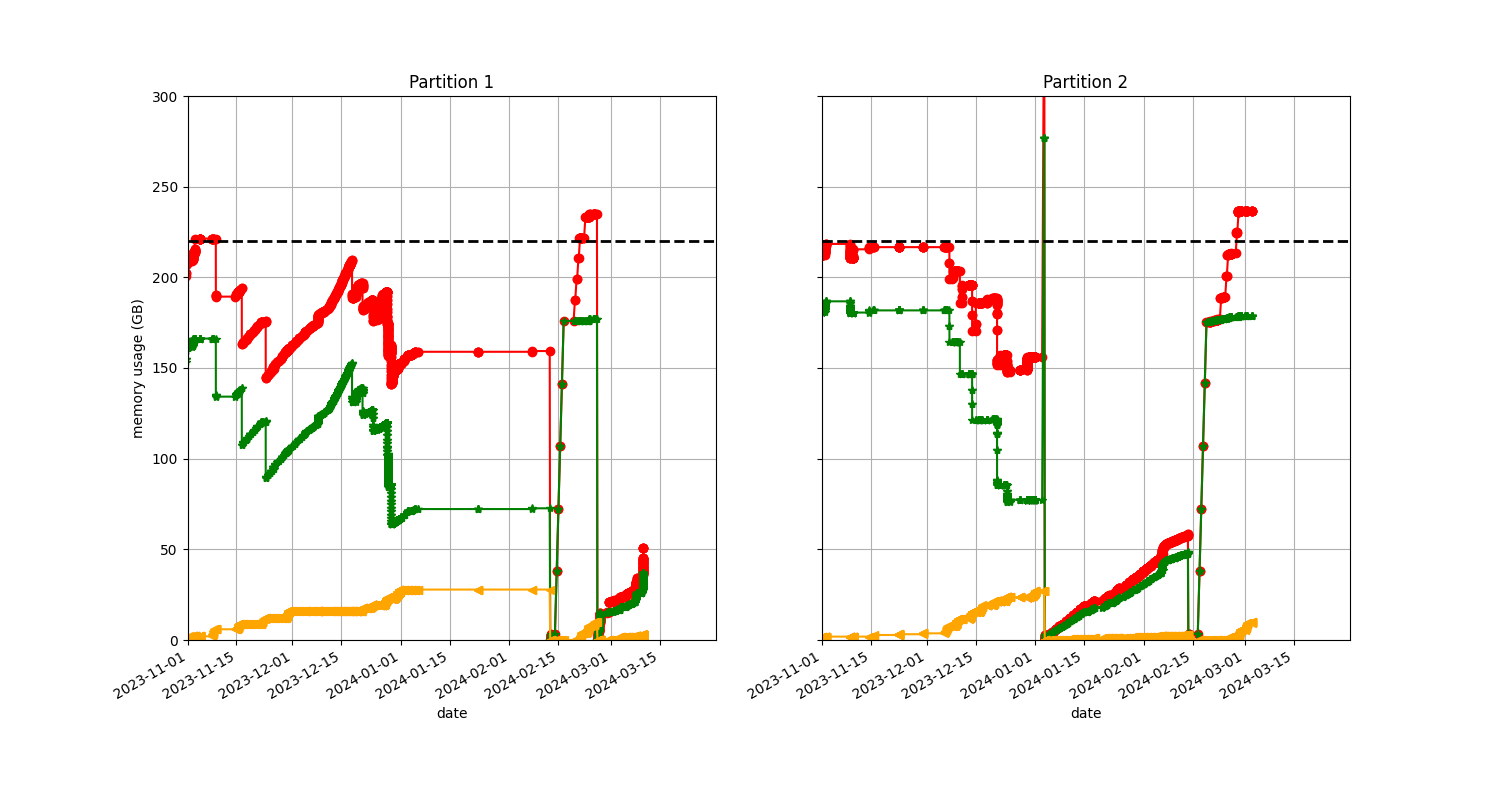

In [7]:
plot_tot(PHI,ylim=(0,300),time_ord=True,xlim=(datetime.datetime(2023,11,1),datetime.datetime(2024,3,31)))

In [6]:
np.where(PHI.part2.history['start'] == datetime.datetime(2023,7,31,2,3,26))
np.sum(PHI.part2.history['compr'][2808:2858])
# PHI.part2.history['start'][2857]


539.5574911999998

In [9]:
temp = PHI.part1.history
s = np.argsort(temp['start'])


y0 = np.asarray(temp['occu'])[s]
y1 = np.asarray(temp['occu'])[s]

x = [None]*(len(y0)+len(y1))
o = [None]*(len(y0)+len(y1))
r = [None]*(len(y0)+len(y1))
c = [None]*(len(y0)+len(y1))

x[::2] = np.asarray(temp['start'])[s]
x[1::2] = np.asarray(temp['end'])[s]; del x[1]
o[::2] = np.cumsum(y0)/1e3
o[1::2] = np.cumsum(y1)/1e3; del o[-1]
r[::2] = np.cumsum(np.asarray(temp['raw'])[s])/1e3
r[1::2] = np.cumsum(np.asarray(temp['raw'])[s])/1e3; del r[-1]
c[::2] = np.cumsum(np.asarray(temp['compr'])[s])/1e3
c[1::2] = np.cumsum(np.asarray(temp['compr'])[s])/1e3; del c[-1]
del y0, y1

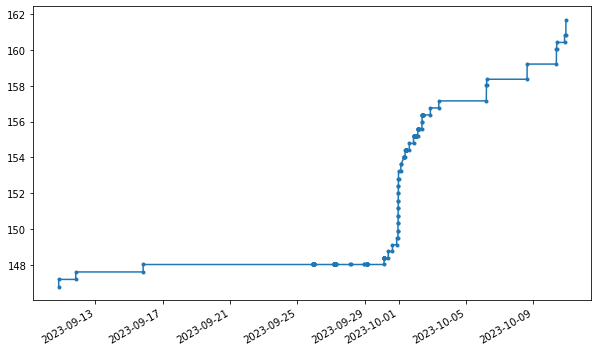

In [34]:
i = 4541#4547
fig = plt.figure(figsize=(10,6))
plt.plot(x[i:],r[i:],'.-'); 
fig.autofmt_xdate()

In [2]:
def simul_syn(cad = [4,4,4,4,4,4,4,4,4], bits = 6, outputs = 24, meta = 0.5):
    """
    1408: 04.26 - 05.01. 6d

    1280: 05.02 - 05.14. 13d

    1024: 05.15 - 05.23. 9d

    896: 05.24. - 06.15. 23d

    768: 06.16. - 08.05. 51d

    896: 08.06. - 08.25. 20d

    1024: 08:26. - 09.05. 11d

    1280: 09.06. - 09.17. 12d

    1408: 09.18. - 09.23. 6d (from 5 to 6, changed by DC to add the whole conjunction, TBC by JH)

    1536: 09.24. - 09.28. 5d (added by DC to add the whole conjunction, TBC by JH)

    """

    crop = [1408,1280,1024,896,768,896,1024,1280,1408,1536]
    duration = [6,13,9,23,51,20,11,12,6,5]

    cad = np.asarray(cad); crop = np.asarray(crop); duration = np.asarray(duration)
    telemetry = duration * cad * (outputs * crop**2 * bits /8e6 + meta)

    print(f"{crop[0]}: 04.26. - 05.01. {duration[0]}d: {cad[0]} datasets/day")
    print(f"{crop[1]}: 05.02. - 05.14. {duration[1]}d: {cad[1]} datasets/day")
    print(f"{crop[2]}: 05.15. - 05.23. {duration[2]}d: {cad[2]} datasets/day")
    print(f"{crop[3]}: 05.24. - 06.15. {duration[3]}d: {cad[3]} datasets/day")
    print(f"{crop[4]}: 06.16. - 08.05. {duration[4]}d: {cad[4]} datasets/day")
    print(f"{crop[5]}: 08.06. - 08.25. {duration[5]}d: {cad[5]} datasets/day")
    print(f"{crop[6]}: 08:26. - 09.05. {duration[6]}d: {cad[6]} datasets/day")
    print(f"{crop[7]}: 09.06. - 09.17. {duration[7]}d: {cad[7]} datasets/day")
    print(f"{crop[8]}: 09.18. - 09.23. {duration[8]}d: {cad[8]} datasets/day")
    print(f"{crop[9]}: 09.24. - 09.28. {duration[9]}d: {cad[9]} datasets/day")

    print('telemetry for each cropping run:',np.round(telemetry,1),'MB')
    print('total telemetry:',np.round(telemetry.sum(),1),'MB')
    # return telemetry


# simul_syn([2,2,2,4,4,4,4,4,4,4])
simul_syn([4,4,4,4,4,4,4,4,4,4])

1408: 04.26. - 05.01. 6d: 4 datasets/day
1280: 05.02. - 05.14. 13d: 4 datasets/day
1024: 05.15. - 05.23. 9d: 4 datasets/day
896: 05.24. - 06.15. 23d: 4 datasets/day
768: 06.16. - 08.05. 51d: 4 datasets/day
896: 08.06. - 08.25. 20d: 4 datasets/day
1024: 08:26. - 09.05. 11d: 4 datasets/day
1280: 09.06. - 09.17. 12d: 4 datasets/day
1408: 09.18. - 09.23. 6d: 4 datasets/day
1536: 09.24. - 09.28. 5d: 4 datasets/day
telemetry for each cropping run: [ 868.4 1559.5  697.5 1375.5 2267.8 1196.1  852.5 1439.6  868.4  859.3] MB
total telemetry: 11984.6 MB


In [58]:
cc = [2048,1920,1792,1664,1536,1408,1280,1152,1024,896,768,640,512]
for c in cc:
    a = PHI_MODE('HRT')
    a.observation(datetime.datetime(2023,1,1,0,0,0),1,1,(2048,2048,4,6))
    a.cropping(a.raw.end,[c,c],1,'raw')
    a.compressing(a.raw.crop.end,6,1,'raw.crop')
    print(c,'x',str(c)+':',round(a.raw.crop.compr.data_tot,1),'MB,',round(a.raw.crop.compr.data_tot*1e6/2**20,1),'MiB')


2048 x 2048: 76.1 MB, 72.6 MiB
1920 x 1920: 66.9 MB, 63.8 MiB
1792 x 1792: 58.3 MB, 55.6 MiB
1664 x 1664: 50.3 MB, 48.0 MiB
1536 x 1536: 42.9 MB, 40.9 MiB
1408 x 1408: 36.0 MB, 34.4 MiB
1280 x 1280: 29.8 MB, 28.4 MiB
1152 x 1152: 24.2 MB, 23.0 MiB
1024 x 1024: 19.1 MB, 18.2 MiB
896 x 896: 14.7 MB, 14.0 MiB
768 x 768: 10.8 MB, 10.3 MiB
640 x 640: 7.5 MB, 7.2 MiB
512 x 512: 4.9 MB, 4.6 MiB


In [3]:
12000/(6+13+9+23+51+20+11+12+6+5)

76.92307692307692

In [106]:
out[2].X*out[2].Y*out[2].P*out[2].L*6/8/2**20 + 0.01 #out[2].compr.metadata/out[2].compr.this_run*1e6/2**20


40.51

In [20]:
obs['0303220101'].raw.pack.compr.data/obs['0303220101'].raw.pack.compr.this_run
obs['0303220101'].raw.pack.compr.__dict__

{'level': 'raw.pack.compr',
 'did': '0343220101',
 'cadence': 1,
 'start': datetime.datetime(2023, 3, 28, 0, 8),
 'n_datasets': 21,
 'end': datetime.datetime(2023, 3, 28, 2, 8, 48, 621312),
 'n_bits': 6,
 'X': 2048,
 'Y': 2048,
 'P': 4,
 'L': 6,
 'n_pix': 100663296,
 'n_outputs': 24,
 'this_run': 12,
 'metadata': 0.10799999999999998,
 'data': 905.969664,
 'data_tot': 1585.635912,
 'not_datasets': 4,
 'interm_data_tot': 0,
 'time': datetime.timedelta(seconds=12685, microseconds=87296),
 'cpu_time': datetime.timedelta(seconds=7248, microseconds=621312)}

In [129]:
# df.iloc[18802]
# obs['0303220001'].raw.crop.pack.start
# levels_did_out(obs['0323211500'])

In [20]:
PHI.part2.history['compr']

[0,
 0,
 0,
 0,
 679.558248,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 75.506472,
 75.506472,
 75.506472,
 75.506472,
 75.506472,
 75.506472,
 6.3004560000000005,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 453.03883199999996,
 254.85796799999997,
 755.0647200000001,
 755.0647200000001,
 377.53236000000004,
 377.53236000000004,
 254.85796799999997,
 42.476327999999995,
 755.0647200000001,
 528.545304,
 302.025888,
 302.025888,
 42.476327999999995,
 302.025888,
 679.558248,
 42.476327999999995,
 226.51941599999998,
 254.85796799999997,
 755.3347200000001,
 755.3347200000001,
 566.50104,
 188.83368000000002,
 424.76327999999995,
 254.85796799999997,
 -10790.524176,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 75.5064

In [36]:
obs['0302090001'].raw.X

2048

In [46]:
df.iloc[13429]
# obs['0203240250']
# obs['025104001']
# find_did(obs,'0251040501')

start    2022-12-15 02:22:24
end      2022-12-15 02:28:24
fcp                  FCP-709
FP_1              0232150111
FP_2                       4
FP_3                       1
FP_4                        
FP_5                        
FP_6                        
FP_7                        
FP_8                        
FP_9                        
FP_10                       
FP_11                       
FP_12                       
FP_13                       
FP_14                       
FP_15                       
FP_16                       
FP_17                       
FP_18                       
FP_19                       
FP_20                       
FP_21                       
FP_22                       
FP_23                       
FP_24                       
FP_25                       
FP_26                       
FP_27                       
FP_28                       
FP_29                       
FP_30                       
FP_31                       
FP_32         

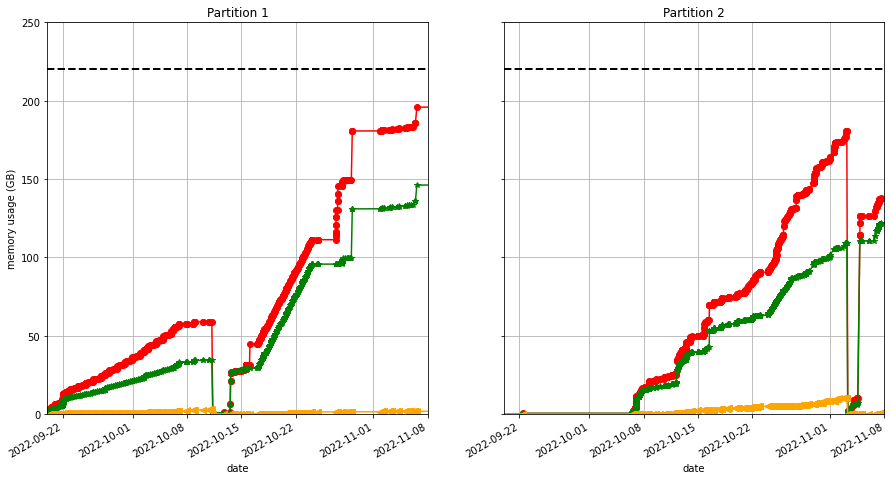

In [6]:
plot_tot(PHI,ylim=(0,250),xlim=(datetime.datetime(2022,9,20),datetime.datetime(2022,11,8)))

In [17]:
np.where(np.asarray(PHI.part1.history['raw'])<0,)
PHI.part2.history['start'][-1]
# PHI.part1.history['start'][1054]
# PHI.part2.history['start'][-1]
# PHI.part1.history['start'][-1]

datetime.datetime(2022, 9, 22, 10, 37, 10)

In [28]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# idx1 = find_nearest(PHI.part1.history['start'],datetime.datetime(2022, 4, 8, 0, 0))
# idx2 = find_nearest(PHI.part2.history['start'],datetime.datetime(2022, 4, 8, 0, 0))
# print((PHI.part1.compr+PHI.part2.compr)*1e6/2**20)

# idx1 = find_nearest(PHI.part1.history['start'],datetime.datetime(2022, 4, 8, 0, 0))
df.query('start == "2022-10-12 22:49:42"')

,start,end,fcp,FP_1,FP_2,FP_3,FP_4,FP_5,FP_6,FP_7,...,FP_26,FP_27,FP_28,FP_29,FP_30,FP_31,FP_32,FP_33,FP_34,FP_35
10467,2022-10-12 22:49:42,2022-10-12 22:51:42,FCP-704,0210120403,,,,,,,...,,,,,,,,,,


In [56]:
a = obs['0210120001']
hasattr(a,'raw')
import inspect
for i in inspect.getmembers(a.raw):
     
    # to remove private and protected
    # functions
    if not i[0].startswith('_'):

        
        # To remove other methods that
        # doesnot start with a underscore
        if not inspect.ismethod(i[1]):
            print(i)

('L', 6)
('P', 4)
('X', 2048)
('Y', 2048)
('cadence', 1.6666666666666667)
('crop', <TMclass.CROP object at 0x7f198556d5b0>)
('data', 408)
('data_tot', 1248)
('end', datetime.datetime(2022, 10, 12, 22, 31, 40))
('metadata', 8)
('n_bits', 32)
('n_datasets', 3)
('n_outputs', 24)
('n_pix', 100663296)
('pack', <TMclass.PACK object at 0x7f198556d1f0>)
('start', datetime.datetime(2022, 10, 12, 22, 30))
('this_run', 1)


(19297.0, 19324.0)

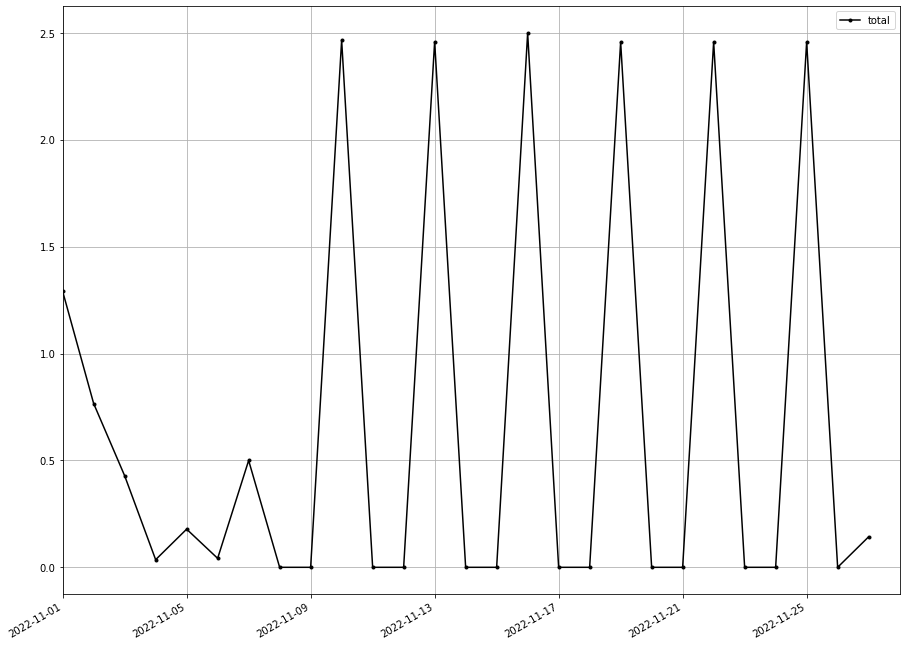

In [7]:
temp = PHI.part1.history    # plt.subplot(121)
c1 = np.asarray(PHI.part1.history['compr'])
c2 = np.asarray(PHI.part2.history['compr'])

d1 = np.asarray(PHI.part1.history['start'])
d2 = np.asarray(PHI.part2.history['start'])

starttime = min(d1[0],d2[0])
endtime = max(d1[-1],d2[-1])
t0 = starttime
times = []
while starttime.date() <= endtime.date():
    times.append(starttime.date())
    starttime += datetime.timedelta(days=1)
starttime = t0; del t0
times_float = [(t - d1[0]).total_seconds() for t in d1]
times = np.asarray(times)

newc1 = np.zeros(np.size(times))
for i,j in zip(d1,c1):
    if j>=0:
        ind = np.where(times == i.date())[0]
        newc1[ind] += j/1e3
newc1 = np.asarray(newc1)

newc2 = np.zeros(np.size(times))
for i,j in zip(d2,c2):
    if j>=0:
        ind = np.where(times == i.date())[0]
        newc2[ind] += j/1e3
newc2 = np.asarray(newc2)


plt.figure(figsize=(15,12))
# plt.plot_date(times,newc1,color='blue',linestyle='-',marker='.',label='partition 1')
# plt.plot_date(times,newc2,color='red',linestyle='-',marker='.',label='partition 2')
plt.plot_date(times,newc1+newc2,color='black',linestyle='-',marker='.',label='total')
plt.gcf().autofmt_xdate()
plt.grid()
plt.legend()
plt.xlim(datetime.datetime(2022,11,1),datetime.datetime(2022,11,28))
